In [1]:
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')

# import modules
import dataloader_paths, dataloader_geo
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
from MOGen_path_prediction import MOGenPathPrediction
import prediction_model_evaluation_metrics as metrics

In [2]:
# Load a network from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_dates = ['202205']
test_dates = ['202206']
DP_tol = 10
min_samples = 13

network_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [3]:
# Load training data from file
path_prefix = '../../data/paths/'
training_paths = dataloader_paths.load_path_training_data(path_prefix, network_name, train_dates)

In [4]:
# Train MOGen Model
model = MOGenPathPrediction()
print(f'Training MOGen Model on {len(training_paths)} paths...')
model.train(training_paths, max_order=3, model_selection=True)

Training MOGen Model on 1433 paths...


order:  3; log_L (8 prcs): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]

Selected optimal maximum order K=1 from candidates.
MOGen model
- Model Selection ------------------------------------
 K  |   nodes     edges   |   log L    dof         AIC
 1  |    676      37557   | -17802.81  1822   39249.63
 2  |   1812      37557   | -14290.97  6141   40863.95
 3  |   3394      37557   | -12477.11 20666   66286.23


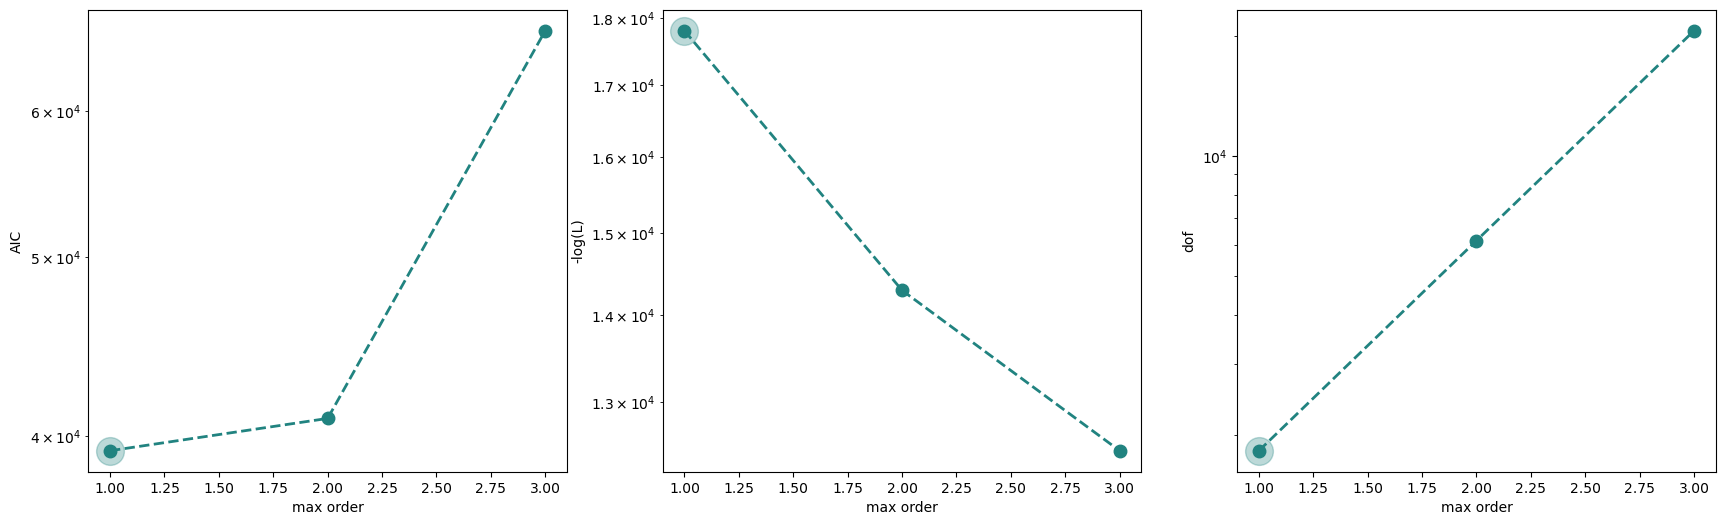

In [5]:
model.model.plot()

In [6]:
# Load test data from file
selection_start = 0
selection_end = 10
selection_step = 2
traj_path_prefix = '../../data/processed/'
test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                  selection_start, selection_end, selection_step)
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [11]:
##### MAKE PREDICTIONS ######
prediction_task = 'next_nodes'  # 'next_nodes' or 'path'
n_walks = 100
n_start_nodes = 1
n_steps = 2        # only needed for next nodes prediction
n_predictions = 1

predictions = model.predict(prediction_task, test_paths, network.G, 
                            n_start_nodes=n_start_nodes, n_steps=n_steps, 
                            n_predictions=n_predictions, n_walks=n_walks)

Making predictions for 5 samples
Progress: 10%...20%...30%...40%...50%...Done!


Evaluating 5 samples for next_nodes prediction task
Progress: 10%...20%...30%...40%...50%...Done!


Time elapsed: 0.00 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 79.71m
Median SSPD: 0.00m
Mean choice_accuracy: 0.8000


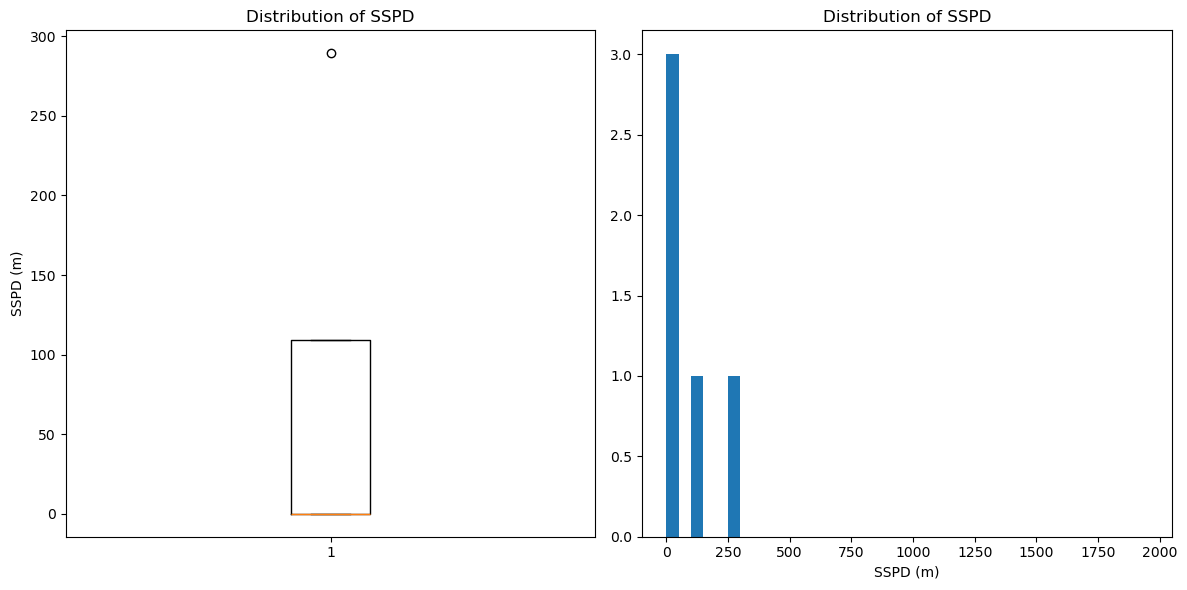

In [14]:
# evaluate
eval_mode = 'trajectory'
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, eval_mode=eval_mode)

In [15]:
evaluation_results

,mmsi,true_path,predicted_path,distances,SSPD,choice_accuracy
0,210055000_0_2022-06-01 09:31:46,"(130, 129, 128)","(130, 129, 128)",[0],0,1.0
0,210189000_0_2022-06-24 06:55:42,"(185, 180, 179)","(185, 180, 179)",[0],0,1.0
0,210189000_8_2022-06-25 16:12:16,"(458, 467, 466)","(458, 467, 466)",[0],0,1.0
0,211102000_0_2022-06-03 02:00:05,"(366, 352, 359)","(366, 357, 361)","[85.77108055210745, 93.78431372158734, 104.703...",289.29858,0.0
0,211102000_6_2022-06-03 20:10:17,"(465, 464)","(465, 464, 472)","[42.734986499584, 25.563960057178413, 13.39449...",109.244037,1.0


In [10]:
# plot predictions with the MOGen model
prediction_task = 'next_nodes'
example = test_paths.iloc[3]
mmsi = example.mmsi
start_node = [example.path[0]]
end_node = example.path[-1]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

if prediction_task == 'next_nodes':
    predictions = model.predict_next_nodes(start_node=start_node, G=network.G, n_predictions=3, n_steps=3, n_walks=200)
if prediction_task == 'path':
    predictions, flag = model.predict_path(start_node, end_node, network.G, n_predictions=5, n_walks=2000, verbose=True)

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+network_name+'_MOGen_predictions.html')
print(f'Map saved under {"../../reports/maps/"+network_name+"_MOGen_predictions.html"}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Map saved under ../../reports/maps/202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM_MOGen_predictions.html
